# SAE Visualizer

This Colab is for demoing the sparse autoencoder feature visualizer that I designed, based on [Anthropic's version](https://transformer-circuits.pub/2023/monosemantic-features/vis/a1.html). It works with TransformerLens' `gelu-1l` model, and the autoencoder trained by Neel Nanda.

More information can be found in my [blog post](https://www.perfectlynormal.co.uk/blog-sae) where I demo this visualizer, and point out a couple of the interesting features.

See the GitHub repo which this notebook clones from [here](https://github.com/callummcdougall/sae_visualizer/tree/main).

My hope is that this visualizer can eventually be built into other open-source SAE libraries, and used for analysis. It's relatively easy to use (just run a function which takes your model, encoder, list of features and a few other parameters, and it spits out an HTML string which can be saved and opened).

Please comment or send me a message if you have any feedback, or there are any specific features you'd like from this visualizer in the future. I hope you find it useful!

<details>
<summary>How the visualizer works (at a high level)</summary>

There are 2 discrete steps:

1. A `FeatureData` class is created, which holds all the information necessary to make the visualisation. This was designed to be pickled and stored (e.g. no massive tensors).
2. This class also has a method `get_all_html` which processes the data into an HTML string, which can then be saved as a file. This HTML string is created from a bunch of regex-y and string operations. It uses some template HTML and CSS files, which are also stored in the sae visualizer repository.

The function to get the initial data needs the model (so that it can perform forward passes to extract activations) and the encoder (so that it can get the feature input & output directions). It also needs the encoder-B which comes from the second run, so we can find correlated features (this is the bottom-left part of the visualization).

My [blog page](https://www.perfectlynormal.co.uk/blog-sae) (where you can navigate through 1000 features) works by querying a database of a bunch of pickled `FeatureData` objects, returning a single one, and running the `get_all_html` function on it, then embedding the result into the page. The `FeatureData` object is designed to be lightweight: 16,384 of them (all the features in the AutoEncoder below) take up just over 100MB, which is obviously more practical than saving them all 16,384 as HTML files given that each one is about 2MB.

</details>

<br>
<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/viz-example.png" width="1000">
<!-- <img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/sae-viz.png" width="320"> -->


# Setup (imports & installs, loading models & data)

In [4]:
!wget https://github.com/callummcdougall/sae_visualizer/archive/refs/heads/main.zip
!unzip ./main.zip

from pathlib import Path
root = Path("sae_visualizer")

%pip install transformer_lens
%pip install plotly
%pip install git+https://github.com/callummcdougall/eindex.git

from IPython.display import display, HTML, clear_output
clear_output()

In [1]:
import os, sys
#os.remove("./main.zip")
sys.path.append("./sae_visualizer")
# set cuda device
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from pathlib import Path
from IPython.display import display, HTML, clear_output


from transformer_lens import HookedTransformer, utils
import torch
from datasets import load_dataset
from typing import Dict
import tqdm.notebook as tqdm
import plotly.express as px
import json

from sae_visualizer.model_fns import AutoEncoderConfig, AutoEncoder
from sae_visualizer.data_fns import get_feature_data, FeatureData

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_grad_enabled(False)

def imshow(x, **kwargs):
    x_numpy = utils.to_numpy(x)
    px.imshow(x_numpy, **kwargs).show()

In [2]:
cfg = AutoEncoderConfig()
cfg

AutoEncoderConfig(seed=42, batch_size=32, buffer_mult=384, epochs=10, lr=0.001, num_tokens=2000000000, l1_coeff=0.0003, beta1=0.9, beta2=0.99, dict_mult=8, seq_len=128, d_mlp=2048, enc_dtype='fp32', remove_rare_dir=False, model_batch_size=64)

In [3]:
device

device(type='cuda')

In [6]:
from torch.utils.data import DataLoader
from text_dataset import TextDataset

#torch.cuda.set_device(1)

model = HookedTransformer.from_pretrained(
        model_name='gpt2-small',
        center_unembed=True,
        center_writing_weights=True,
        fold_ln=True,
        refactor_factored_attn_matrices=True,
    ).to(device)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


In [50]:
dataset = load_dataset("togethercomputer/RedPajama-Data-1T-Sample", split="train")
#dataset = load_dataset("roneneldan/TinyStories")['train']
text_dataset = TextDataset(dataset, model.to_tokens, 50000, drop_last_batch=False,
                               seq_len=512)
# don't increase num_workers > 1 because it's an IterableDataset and multiple dataloaders will yield the same data
text_dataset_loader = iter(DataLoader(text_dataset, batch_size=None, shuffle=False, num_workers=0))
all_tokens = next(text_dataset_loader)
all_tokens[:, 0] = model.tokenizer.bos_token_id
all_tokens.shape

Found cached dataset red_pajama-data-1_t-sample (/var/local/glang/.cache/huggingface/datasets/togethercomputer___red_pajama-data-1_t-sample/plain_text/1.0.0/6ea3bc8ec2e84ec6d2df1930942e9028ace8c5b9d9143823cf911c50bbd92039)


torch.Size([50000, 512])

In [51]:
# reimport
import importlib
import SparseAutoencoder
importlib.reload(SparseAutoencoder)
from SparseAutoencoder import SparseAutoencoder


# encoder = SparseAutoencoder.load_from_checkpoint('models/sae_0.5B_l1=1e-2_lr=2e-4_tinystories_8x.ckpt', model, text_dataset, map_location='cuda')
encoder = SparseAutoencoder.load_from_checkpoint('models/sae_0.5B_l1=1e-2_lr=2e-4_redpajama_8x.ckpt', model, text_dataset, map_location='cuda')

# encoder_B = AutoEncoder.load_from_hf(version="run2")

In [11]:
ioi_pos_dir = torch.tensor([ 0.0280, -0.0011, -0.0015,  0.0149,  0.1153,  0.0617, -0.0031,  0.0309,
        -0.0612,  0.0238, -0.0061, -0.0379,  0.0285,  0.0258, -0.0380,  0.0751,
         0.0506,  0.0480,  0.0231,  0.0036,  0.0080,  0.0025, -0.0323, -0.0120,
        -0.0072,  0.0255, -0.0255,  0.0114, -0.0061, -0.0369,  0.0403, -0.0747,
         0.0607, -0.0146,  0.0021, -0.0669,  0.0448, -0.0111,  0.0752,  0.0112,
        -0.0426,  0.0016,  0.0108, -0.0059,  0.0402,  0.0484,  0.0557,  0.0025,
        -0.0711,  0.0039,  0.0314, -0.0584, -0.0895, -0.0534,  0.0118, -0.0319,
        -0.0220,  0.0539,  0.0215,  0.0382, -0.0262, -0.0348,  0.0007, -0.0554,
        -0.0536, -0.0025, -0.0076, -0.0107, -0.0043,  0.0441, -0.0327, -0.0363,
        -0.0178,  0.0033,  0.0060, -0.1075, -0.0095, -0.0658, -0.0406,  0.0114,
         0.0569,  0.0081,  0.0475, -0.0459, -0.0674,  0.0042,  0.0483, -0.0045,
         0.0213,  0.0008, -0.0150, -0.0437,  0.0473,  0.0921,  0.0288,  0.0131,
         0.0215, -0.0013, -0.0448,  0.0529, -0.0017,  0.0320, -0.0189, -0.0040,
         0.0421, -0.0322,  0.0186, -0.0146,  0.0098,  0.0386, -0.0408,  0.0025,
        -0.0458, -0.0031, -0.0412, -0.0188, -0.0379,  0.0438,  0.0239,  0.0035,
         0.0152, -0.0175,  0.0346,  0.0178,  0.0184, -0.0564,  0.0301, -0.0097,
         0.0254, -0.0538,  0.0275,  0.0032, -0.0042,  0.0755, -0.0416,  0.0059,
         0.0006,  0.0104, -0.0751, -0.0120,  0.0435, -0.0572, -0.0353, -0.0334,
         0.0662, -0.0577,  0.0012, -0.0033, -0.0037, -0.0499, -0.0412,  0.0325,
        -0.0899, -0.0003, -0.0372,  0.0040,  0.0233, -0.0145, -0.0126,  0.0206,
        -0.0344, -0.0324, -0.0370,  0.0075, -0.0169,  0.0084, -0.0359,  0.0022,
        -0.0421,  0.0334,  0.0150,  0.0166, -0.0013,  0.0429, -0.0038,  0.0195,
        -0.0374, -0.0268,  0.0137, -0.0141,  0.0554,  0.1044,  0.0251, -0.0332,
        -0.0239,  0.0209, -0.0245, -0.0507,  0.0426,  0.0073,  0.0071, -0.0003,
         0.0098, -0.0146, -0.0186, -0.0220, -0.0287, -0.0198,  0.0080,  0.0102,
        -0.0062, -0.0418,  0.0628, -0.0315, -0.0165, -0.0228, -0.0970,  0.0432,
         0.0058,  0.0259, -0.0634,  0.0211, -0.0327, -0.0117, -0.0106, -0.0216,
        -0.0213, -0.0006,  0.0214, -0.0270,  0.0019,  0.0176,  0.0369, -0.0279,
        -0.0167, -0.0423, -0.0492,  0.0263,  0.0176, -0.0758,  0.0150, -0.0557,
         0.0207,  0.0065,  0.0077,  0.0232,  0.0529, -0.0043,  0.0569, -0.0155,
        -0.0336, -0.0585,  0.0417, -0.0369,  0.0617, -0.0348,  0.0045, -0.0048,
         0.0259,  0.0030,  0.0005,  0.0094, -0.0359,  0.0052,  0.0195,  0.0402,
        -0.0062, -0.0314,  0.0640, -0.0256,  0.0149,  0.0011,  0.0161,  0.0167,
         0.0236,  0.0309, -0.1036, -0.1146, -0.0609, -0.0062,  0.0073,  0.0163,
         0.0549,  0.0066,  0.0264,  0.0286, -0.0604,  0.0209,  0.0666, -0.0240,
        -0.0509,  0.0231, -0.0144,  0.0010,  0.0249,  0.0013, -0.0390, -0.0257,
         0.0446,  0.0256,  0.0832, -0.0545,  0.0146,  0.0257, -0.0147,  0.0088,
         0.0440, -0.0226,  0.0392, -0.0320,  0.0050,  0.0102, -0.0140, -0.0496,
         0.0064, -0.0010, -0.0716,  0.0036, -0.0245, -0.0625,  0.0274, -0.0280,
        -0.0355, -0.0154,  0.0341, -0.0902,  0.0358, -0.0194, -0.0589,  0.0120,
         0.0800,  0.0028,  0.0050,  0.0610, -0.0055,  0.0276,  0.0492,  0.0889,
        -0.0141,  0.0704, -0.0210,  0.0072,  0.0451,  0.0296,  0.0082,  0.0055,
        -0.0195,  0.0076,  0.0290, -0.0193, -0.0165,  0.0165, -0.0060,  0.0363,
         0.0095, -0.0119,  0.0093, -0.0099, -0.0310, -0.0428,  0.0135,  0.0101,
        -0.0294,  0.0310, -0.0628,  0.0223, -0.0590,  0.0529, -0.0594,  0.0540,
         0.0258,  0.0113,  0.0043,  0.0572, -0.0076, -0.0132,  0.0450,  0.0366,
         0.0494,  0.0584, -0.0230, -0.0197,  0.0450,  0.0291, -0.0821, -0.0739,
        -0.0087, -0.0541,  0.0650,  0.0398,  0.0106,  0.0089, -0.0418,  0.0759,
         0.0086,  0.0654,  0.0121,  0.0118,  0.0111,  0.0103, -0.0235, -0.0106,
         0.0231,  0.0469,  0.0008,  0.0345,  0.0460,  0.0363,  0.0106,  0.0117,
         0.0183,  0.0481, -0.0118, -0.0374,  0.0214, -0.0261, -0.0058,  0.0094,
        -0.0351,  0.0063,  0.0194, -0.0198, -0.0029,  0.0342,  0.0502,  0.0151,
         0.0143, -0.0132, -0.0377, -0.0406,  0.0096,  0.0305, -0.0083, -0.0352,
        -0.0377, -0.0222, -0.0076, -0.0420, -0.0980, -0.0238,  0.0095, -0.0346,
        -0.0142,  0.0642,  0.0514, -0.0013, -0.0551, -0.0235, -0.0368,  0.0316,
         0.0092, -0.0285,  0.0426, -0.0666,  0.0024, -0.0447,  0.0099, -0.0147,
         0.0514, -0.0157,  0.0309, -0.0078, -0.0067, -0.0453,  0.0151,  0.0390,
         0.0310, -0.0569,  0.0254, -0.0518,  0.0480,  0.0288,  0.0111, -0.0151,
        -0.0284, -0.0735, -0.0117, -0.0371,  0.0395, -0.0001, -0.0017, -0.0167,
        -0.0443, -0.0175, -0.0215,  0.0588, -0.0239,  0.0294,  0.0220,  0.0078,
        -0.0099,  0.0370,  0.0308, -0.0129, -0.0099, -0.0219, -0.0680,  0.0822,
         0.0216,  0.0095, -0.0649, -0.0170, -0.0309, -0.0009,  0.0184, -0.0079,
        -0.0458, -0.0236, -0.0116, -0.0075,  0.0181,  0.0450, -0.0182, -0.0422,
        -0.0409,  0.0046,  0.0393,  0.0028,  0.0093,  0.0282, -0.0167, -0.1168,
        -0.0399, -0.0457, -0.0335, -0.0249,  0.0531, -0.0069,  0.0103, -0.0112,
        -0.0635,  0.0142, -0.0408, -0.0353,  0.0298,  0.0020, -0.0198, -0.0142,
        -0.0080,  0.0443, -0.0276,  0.0369,  0.0054, -0.0495,  0.0093,  0.0568,
        -0.0529,  0.0294,  0.0369, -0.0090, -0.0159, -0.0250, -0.0231,  0.0013,
         0.0402, -0.0538, -0.0016, -0.0175,  0.0229, -0.0248, -0.0283,  0.0660,
        -0.0266, -0.0391, -0.0320,  0.0683,  0.0792, -0.0105, -0.0633, -0.0309,
         0.0541, -0.0257,  0.0392, -0.0206, -0.0252, -0.0093,  0.0255, -0.0335,
         0.0117,  0.0192,  0.0497, -0.0247,  0.0331, -0.0174, -0.0358,  0.0203,
         0.0098, -0.0436, -0.0040,  0.0342, -0.0220,  0.0562,  0.0212, -0.0242,
         0.0044,  0.0427,  0.0247,  0.0205, -0.0224,  0.0033, -0.0611,  0.0298,
        -0.0346,  0.0536,  0.0308,  0.0267,  0.0093,  0.0544, -0.0089, -0.0486,
        -0.0722,  0.0287,  0.0067,  0.0057,  0.0091,  0.0087,  0.0402, -0.0337,
        -0.0254,  0.0345,  0.0197,  0.0196, -0.0108,  0.0446, -0.0183, -0.0122,
        -0.0393, -0.0281,  0.0408, -0.0678, -0.0042,  0.0239,  0.0077, -0.0162,
        -0.0618, -0.0065, -0.0161,  0.0479,  0.0083, -0.0240,  0.0201,  0.0248,
        -0.0103,  0.0859, -0.0034, -0.0145, -0.0180, -0.0211,  0.0497,  0.0711,
         0.0194, -0.0341,  0.0291, -0.0822,  0.0102,  0.0602, -0.0050,  0.0473,
         0.0517, -0.0334,  0.0248,  0.0282,  0.0231, -0.0075, -0.0158, -0.0164,
        -0.0180, -0.0170, -0.0436,  0.0130, -0.0288, -0.0090,  0.0468, -0.0562,
        -0.0351,  0.0052,  0.0394,  0.0412,  0.0259, -0.0297, -0.0094, -0.0305,
        -0.0075,  0.0175,  0.0034,  0.0280, -0.0594,  0.0044, -0.0069, -0.0250,
        -0.0572,  0.0482,  0.0209, -0.0701,  0.0260, -0.0119,  0.0331, -0.0471,
        -0.0577, -0.0164,  0.0019, -0.0195, -0.0136,  0.0039, -0.0267, -0.0219,
         0.0544,  0.0286,  0.0110,  0.0101,  0.0257,  0.0558, -0.0344, -0.0021,
        -0.0030, -0.0198,  0.0071,  0.0021, -0.0011,  0.0573, -0.0226,  0.0082,
         0.0757, -0.0330,  0.0099, -0.0008,  0.0346, -0.0728,  0.0172,  0.0007,
        -0.0089, -0.0131,  0.0180,  0.0159, -0.0166,  0.0361, -0.0151, -0.0294,
        -0.0166,  0.0170,  0.0112,  0.0078, -0.0168, -0.0480, -0.0150,  0.0062,
        -0.0197, -0.0192, -0.0050,  0.0446, -0.0188,  0.0110,  0.0032,  0.0131,
        -0.0164, -0.0337, -0.0430, -0.0181,  0.0346,  0.0211,  0.0254, -0.0849,
         0.0657, -0.0288,  0.0507, -0.0264,  0.0106,  0.0187, -0.0141,  0.0751,
         0.0102, -0.0063,  0.0732,  0.0232,  0.0536, -0.0669, -0.0026, -0.0226], device='cuda')

In [12]:
encoder.sae.decoder_map.weight.shape

torch.Size([768, 6144])

In [16]:
encoder.to('cuda')
checkpoint = torch.load("models/sae_0.5B_l1=1e-2_lr=2e-4_tinystories_8x.ckpt", map_location='cuda')
state_dict = checkpoint['state_dict']
# filter for sae.
state_dict = {k: v for k, v in state_dict.items() if k.startswith('sae')}
# remove sae. prefix
state_dict = {k[4:]: v for k, v in state_dict.items()}
encoder.sae.load_state_dict(state_dict)

<All keys matched successfully>

In [17]:
def cosine_sim(a, b):
    return (a @ b) / (a.norm() * b.norm())

sims = []
for i in range(encoder.sae.decoder_map.weight.shape[1]):
    sims.append(
        cosine_sim(
            encoder.sae.decoder_map.weight[:, i],
            ioi_pos_dir,
        )
    )

In [18]:
max(sims), min(sims)

(tensor(0.1517, device='cuda:0'), tensor(-0.1168, device='cuda:0'))

TypeError: can't convert cuda:1 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

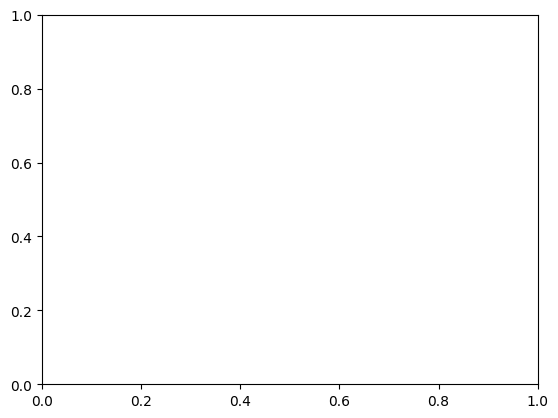

In [32]:
from matplotlib import pyplot as plt

plt.bar(range(len(sims)), sims)

In [22]:
# Save vocab dict as JSON, i.e. {str(token_id): str_token}

vocab_dict = {str(v): k.replace("Ġ", " ").replace("\n", "\\n") for k, v in model.tokenizer.vocab.items()}

vocab_dict_filepath = Path("sae_visualizer/vocab_dict.json")
if not vocab_dict_filepath.exists():
    with open(vocab_dict_filepath, "w") as f:
        json.dump(vocab_dict, f)

In [54]:
def get_feature_freq_histogram(model, encoder, all_tokens, num_features):
    device = 'cuda'
    model.to(device)
    encoder.to(device)
    features = torch.zeros(num_features, device='cpu')
    batch_size = 40
    for i in tqdm.trange(0, all_tokens.shape[0], batch_size):
        batch = all_tokens[i:i+batch_size].to(device)
        l, cache = model.run_with_cache(batch, names_filter = lambda name_: 'blocks.8.hook_resid_post' in name_)
        X = cache['blocks.8.hook_resid_post']
        recons, feature = encoder(X)  # X are activations
        features += (feature[:, :, :] > 1e-6).sum(dim=[0, 1]).cpu()
    features /= all_tokens.shape[0] * all_tokens.shape[1]
    return features
hist = get_feature_freq_histogram(model, encoder, all_tokens, 8 * 768)

Moving model to device:  cuda


  0%|          | 0/1250 [00:00<?, ?it/s]

torch.Size([6144])


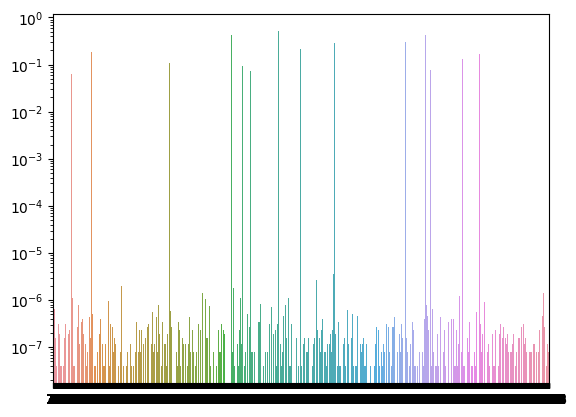

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
print(hist.shape)
sns.barplot(y=hist.numpy(), x=np.arange(len(hist)))
plt.yscale('log')

Text(0.5, 1.0, 'Feature frequency histogram')

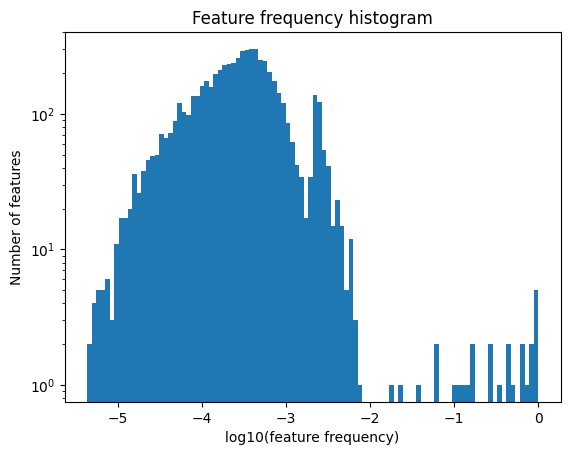

In [55]:
plt.hist(np.log10(hist.numpy() + 1e-8), bins=100)
plt.yscale('log')
plt.ylabel('Number of features')
plt.xlabel('log10(feature frequency)')
plt.title('Feature frequency histogram')

In [58]:
torch.cuda.set_device(3)

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [57]:
print(torch.cuda.device_count())  # This should print '1' if GPU 3 is available
print(torch.cuda.get_device_name(0))

1
Tesla V100-PCIE-32GB


Text(0.5, 1.0, 'Feature frequency histogram')

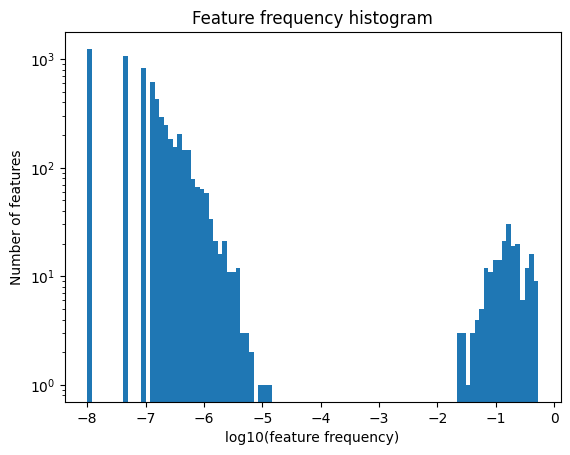

In [47]:
plt.hist(np.log10(hist.numpy() + 1e-8), bins=100)
plt.yscale('log')
plt.ylabel('Number of features')
plt.xlabel('log10(feature frequency)')
plt.title('Feature frequency histogram')

In [49]:
(np.log10(hist.numpy() + 1e-8) > -4).sum()

203

In [19]:
device = 'cuda'
model.to(device)
encoder.to(device)
features = torch.empty((all_tokens.shape[0], all_tokens.shape[1], 50), device='cpu')
batch_size = 50
for i in tqdm.trange(0, all_tokens.shape[0], batch_size):
    batch = all_tokens[i:i+batch_size].to(device)
    l, cache = model.run_with_cache(batch, names_filter = lambda name_: 'blocks.8.hook_resid_post' in name_)
    X = cache['blocks.8.hook_resid_post']
    recons, feature = encoder(X)  # X are activations
    features[i:i+batch_size] = feature[:, :, :50].cpu()
recons.shape, features.shape

Moving model to device:  cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

(torch.Size([50, 512, 768]), torch.Size([50000, 512, 50]))

In [23]:
for f in range(50):
    print(f, (features[:, :, f] > 1e-6).sum())

0 tensor(1)
1 tensor(4)
2 tensor(6)
3 tensor(14)
4 tensor(1)
5 tensor(3)
6 tensor(0)
7 tensor(7)
8 tensor(0)
9 tensor(3)
10 tensor(1)
11 tensor(2)
12 tensor(0)
13 tensor(0)
14 tensor(1)
15 tensor(17)
16 tensor(2071474)
17 tensor(25)
18 tensor(3758327)
19 tensor(0)
20 tensor(0)
21 tensor(6)
22 tensor(0)
23 tensor(0)
24 tensor(4)
25 tensor(3)
26 tensor(4)
27 tensor(4)
28 tensor(4)
29 tensor(1)
30 tensor(8)
31 tensor(3)
32 tensor(9)
33 tensor(4667778)
34 tensor(3)
35 tensor(4272671)
36 tensor(0)
37 tensor(8)
38 tensor(0)
39 tensor(0)
40 tensor(1)
41 tensor(3)
42 tensor(5)
43 tensor(0)
44 tensor(3)
45 tensor(6)
46 tensor(3)
47 tensor(0)
48 tensor(74)
49 tensor(0)


In [124]:
feature_0.flatten()[feature_0.argmax()]
# get the batch number of the max activation
batch_num = feature_0.argmax() // feature_0.shape[1]

In [125]:
html = circuitsvis.tokens.colored_tokens(model.to_str_tokens(all_tokens[batch_num]), feature_0[batch_num])._repr_html_()
# save to file
with open("test.html", "w") as f:
    f.write(html)

In [20]:
import os
import circuitsvis

# Ensure the 'html' directory exists
os.makedirs('html', exist_ok=True)

# Iterate over each feature
for feature_idx in range(features.shape[2]):
    feature = features[:, :, feature_idx]

    # Process only if the maximum activation is greater than zero
    if feature.max() > 0:
        # Get indices of the top 5 activations
        top_indices = feature.flatten().argsort()[-5:]

        # Initialize lists to store tokens and corresponding values
        all_tokens_combined = []
        all_values_combined = []

        # Collect tokens and values for the top 5 activations
        for idx in top_indices:
            batch_num = idx // feature.shape[1]
            token_index = idx % feature.shape[1]
            
            # Append the tokens and their corresponding values
            all_tokens_combined.extend(model.to_str_tokens(all_tokens[batch_num]))
            all_values_combined.extend(feature[batch_num].numpy())
            
        # to float
        all_values_combined = [float(v) for v in all_values_combined]
        

        # Generate colored tokens HTML
        concatenated_html = circuitsvis.tokens.colored_tokens(all_tokens_combined, all_values_combined)._repr_html_()

        # Save the concatenated HTML to a file
        save_path = os.path.join('html', f'feature_{feature_idx}.html')
        with open(save_path, 'w') as f:
            f.write(concatenated_html)


In [81]:
torch.max(features, dim=[0, -2]).values[:, 0]

TypeError: max() received an invalid combination of arguments - got (Tensor, dim=list), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)


In [118]:
circuitsvis.tokens.colored_tokens(["hallo ", 'World'], [0, 1])._repr_html_()

'<div id="circuits-vis-4f3086fa-0cae" style="margin: 15px 0;"/>\n    <script crossorigin type="module">\n    import { render, ColoredTokens } from "https://unpkg.com/circuitsvis@1.40.0/dist/cdn/esm.js";\n    render(\n      "circuits-vis-4f3086fa-0cae",\n      ColoredTokens,\n      {"tokens": ["hallo ", "World"], "values": [0, 1]}\n    )\n    </script>'

# Creating visualizations

In [23]:
# this determines the chunks to break up batch into (for fwd passes)
max_batch_size = 128

# total number of datapoints (seq_len=128)
total_batch_size = 4096

# list of features you're getting data for
feature_idx = list(range(500))

In [30]:
feature_data: Dict[int, FeatureData] = get_feature_data(
    encoder = encoder,
    encoder_B = encoder,
    model = model,
    tokens = all_tokens[:total_batch_size],
    feature_idx = feature_idx,
    max_batch_size = max_batch_size,
    left_hand_k = 3,
    buffer = (5, 5),
    n_groups = 10,
    first_group_size = 20,
    other_groups_size = 5,
    verbose = True,
)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (500x65536 and 3072x768)

# Saving / displaying visualizations

Here's some code to save the visualisation. It looks a bit janky in Colab dark mode, so you might want to try switching to light mode (or just downloading and opening it in a browser).

In [11]:
# Get the HTML string for a particular feature (#8 is interesting!)
html_str = feature_data[test_idx := 8].get_all_html()

# Save the feature
with open(f"/content/feature_{test_idx:04}.html", "w") as f: f.write(html_str)

# Display inline
display(HTML(html_str))

Index,Value,% of L1
474,+0.44,0.9%
252,+0.33,0.7%
1653,+0.31,0.7%
Index,Pearson Corr.,Cosine Sim.
1292,+0.16,+0.15
1147,+0.14,+0.12
252,+0.11,+0.11
Index,Pearson Corr.,Cosine Sim.
13927,+0.78,+0.78
8793,+0.20,+0.20
